# Progress report

- Our task was to come up with pedagogical examples demonstrating that the problem of miscalibration of the posterior predictive exists, as well as show why it exists for Bayesian neural networks.
- We set to establish a causal link between each aspect of the model building process and a bad miscalibrated outcome.
- One line of research was to pick a very simple data-generating function $y_i = 0.1 x_i^3 + \varepsilon$, where $\varepsilon \sim \mathcal{N}(0, 0.5^2)$ and evaluate the impact on the posterior predictive of the following aspects:

  - The likelihood specification, in particular, the variance of the noise
  - The prior on the neural network weights
  - Network complexity
  - Different inference methods

In [1]:
import warnings

from autograd import numpy as np
import arviz as az
import pymc3 as pm
import scipy.stats
import theano

import matplotlib.pyplot as plt
%matplotlib inline

%run helpers.ipynb
%run neuralnet.ipynb

In [2]:
# Ignore PyMC3 FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Display all columns of a dataframe
pd.set_option('display.max_columns', None)

# Make plots larger by default
plt.rc('figure', dpi=100)

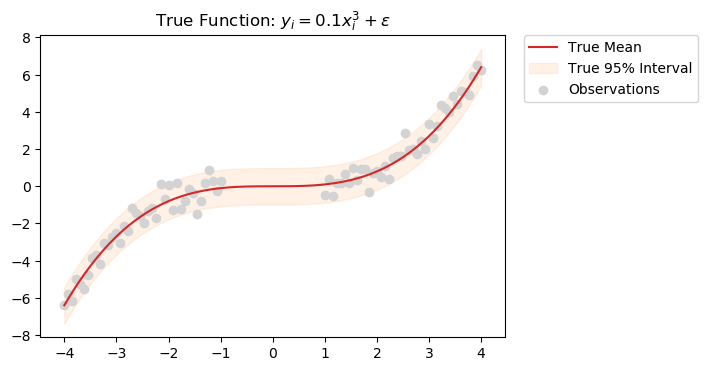

In [3]:
# Define the true function and generate observations
func = lambda x: scipy.stats.norm(loc=0.1 * x**3, scale=0.5)
func.latex = r'$y_i = 0.1x_i^3 + \varepsilon$'

data_points = [
    { 'n_points': 40, 'xlim': [-4, -1] },
    { 'n_points': 40, 'xlim': [1, 4] },
]
df = generate_data(func, points=data_points, seed=4)

# Plot the data
plot_true_function(func, df, title=f'True Function: {func.latex}')

Next, we fit neural networks to the observed data to obtain maximum likelihood estimates of the weights. These will be used as HMC/NUTS sampler initializations.

Network configurations considered: 3, 10 and 50 nodes in a single hidden layer.

In [6]:
# Fit a neural network with a speficied number of nodes in a single hidden layer
width = 50
nn = SimpleNN(width=width, num_iters=5_000, step_size=0.01,
              checkpoint=1000, seed=0)
nn.fit(df.x, df.y)

[Iteration    1] Sum of squared errors: 2908.909154
[Iteration 1000] Sum of squared errors: 16.967336
[Iteration 2000] Sum of squared errors: 15.072368
[Iteration 3000] Sum of squared errors: 14.335296
[Iteration 4000] Sum of squared errors: 13.830800
[Iteration 5000] Sum of squared errors: 13.525531


No regularization was applied, so overfitting was apparent for all but the simplest models.

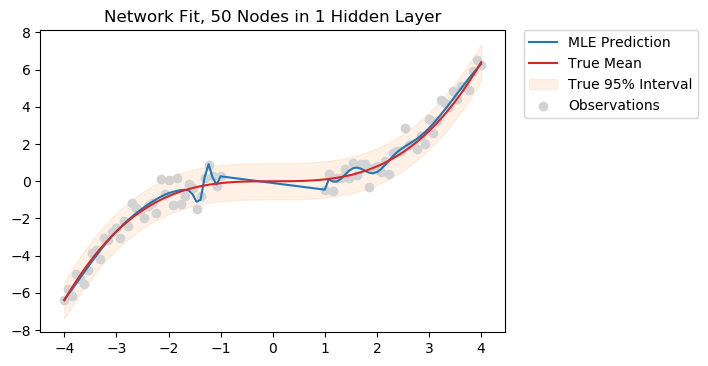

In [8]:
# Plot MLE predictions. Overfitting is usually expected.
y_pred = nn.predict(df.x)
plt.plot(df.x, y_pred, label='MLE Prediction')
plot_true_function(func, df,
                   title=f'Network Fit, {width} Nodes in 1 Hidden Layer')

In [ ]:
x_input = theano.shared(df[['x']].values)
y_output = theano.shared(df['y'].values)

We then build multiple BNN models with:

- different values of the noise in the likelihood function: 0.1, 0.5 (true noise), 1.0
- several priors on the weights: from 0.1 to 10.0 depending on model complexity

Below is an example of a BNN with 50 nodes in 1 hidden layer, true noise and the prior variance of 1.0:

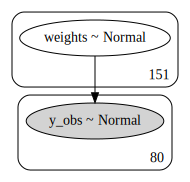

In [9]:
# Standard deviation of the prior
sigma = 1.0
# Standard deviation of the likelihood, 0.5 is the true noise
noise = 0.5

# Build a hierarchical Bayesian neural network. Initialize with MLE.
model = build_model(x_input, y_output, sigma, noise, width,
                    n_weights=nn.n_weights, init=nn.weights)

# Visualize the model
pm.model_to_graphviz(model)

We then obtain the posterior of the model by:

- sampling from it with the No-U-Turn algorithm, as implemented in PyMC3
- approximating the posterior with Automatic Differentiation Variational Inference (inspired by Bayes by Backprop), again using PyMC3

So far we haven't used multiple random restarts since sampling even a relatively small number of samples with NUTS was particularly slow. Therefore, the results may be subject to randomness.

We checked for convergence using trace plots, the effective sample size, and Gelman-Rubin tests. Some of the smaller models with few nodes and narrow priors have not converged.

In [ ]:
with model:
    # Sample from the posterior using the No-U-Turn sampler
    trace = pm.sample(draws=5000, tune=5000, init="adapt_diag",
                      target_accept=0.9, cores=2, random_seed=[1, 2])
    
    # Approximate the posterior using variational inference
    mean_field = pm.fit(20_000, method='advi', obj_n_mc=10,
                        obj_optimizer=pm.adagrad())
    trace_advi = mean_field.sample(10_000)

Finally, we simulate the posterior predictive for 1000 equally spaced values of $x$ and plot the results.

First, the effect of the prior. A reasonably well-selected prior allows a BNN to adequately reflect both epistemic and aleatoric uncertainty:

<img src="fig/NUTS_hidden_1_width_50_sigma_1.0_noise_0.5.png">

Higher prior variance results in a significantly larger epistemic uncertainty. Calibration will not help in this case, since there is no data: 

<img src="fig/NUTS_hidden_1_width_50_sigma_1.5_noise_0.5.png">

Lower prior variance does not adequately reflect epistemic uncertainty in areas where no data is available.

It also introduces bias: a neural network even with 50 nodes is unable to fit a cubic function.


<img src="fig/NUTS_hidden_1_width_50_sigma_0.5_noise_0.5.png">

The bias becomes apparent with even smaller prior on the weights. This is a major issue with the model that needs to be fixed. Calibration is inappropriate in this case.

<img src="fig/NUTS_hidden_1_width_50_sigma_0.1_noise_0.5.png">

The appropriate level of the prior variance depends on the network complexity. Here once again is the network with 50 nodes an prior variance of 1.0:

<img src="fig/NUTS_hidden_1_width_50_sigma_1.0_noise_0.5.png">

A simpler network with 10 nodes and the same prior variance of 1.0 has much lower epistemic uncertainty. Therefore, the prior has to be selected for each particular network configuration.

<img src="fig/NUTS_hidden_1_width_10_sigma_1.0_noise_0.5.png">

The effect of wrong noise in the likelihood function — aleatoric uncertainty is captured incorrectly. This may be a good candidate for calibration. Alternatively, one could find ways for the network to learn the noise from the data.

<img src="fig/NUTS_hidden_1_width_50_sigma_1.0_noise_1.0.png">

Similarly, if the noise is too small, aleatoric uncertainty is unrealistically low:

<img src="fig/NUTS_hidden_1_width_50_sigma_1.0_noise_0.25.png">

Using approximate methods of inference is also likely to lead to a miscalibrated posterior predictive. In the example below, Automatic Differentiation Variational Inference on a network with 50 nodes produces too low epistemic uncertainty and slightly larger aleatoric uncertainty. Calibration may be used for correcting the latter.

<img src="fig/ADVI_hidden_1_width_50_sigma_1.0_noise_0.5.png">

Approximate inference methods should be evaluated on a case by case basis. In some configurations they work really well:

<img src="fig/ADVI_hidden_1_width_10_sigma_2.0_noise_0.5.png">

# Next steps
    
- Further research on the issue of miscalibration. In particular the statement from the paper: "if the true data distribution $P(Y | X)$ is not Gaussian, uncertainty estimates derived from the Bayesian model will not be calibrated".
- Investigate the role of non-identifiability in the likelihood
- Implement the calibration algorithm with a sigmoid and isotonic regressions, as proposed by the authors
- Perform calibration of select models
- Investigate calibration metrics and quantitatively analyze the results